<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E10-TwitterNetworkAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Network Analysis
This notebook contains a social network analysis mainly executed with the library of NetworkX. In detail, this dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks. The dataset can be found at this link: [Stanford Twitter Dataset](https://snap.stanford.edu/data/ego-Twitter.html).

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [ ]:
twitter = pd.read_csv(
    "https://snap.stanford.edu/data/twitter_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
twitter = twitter.iloc[:80000]

The graph is created from the `twitter` dataframe of the edges:

In [ ]:
G = nx.from_pandas_edgelist(twitter, "start_node", "end_node")

## Visualizing the graph

Let's start our exploration by visualizing the graph. Visualization plays a
central role in exploratory data analysis to help get a qualitative feel for
the data.

Since we don't have any real sense of structure in the data, let's start by
viewing the graph with `random_layout`, which is among the fastest of the layout
functions.

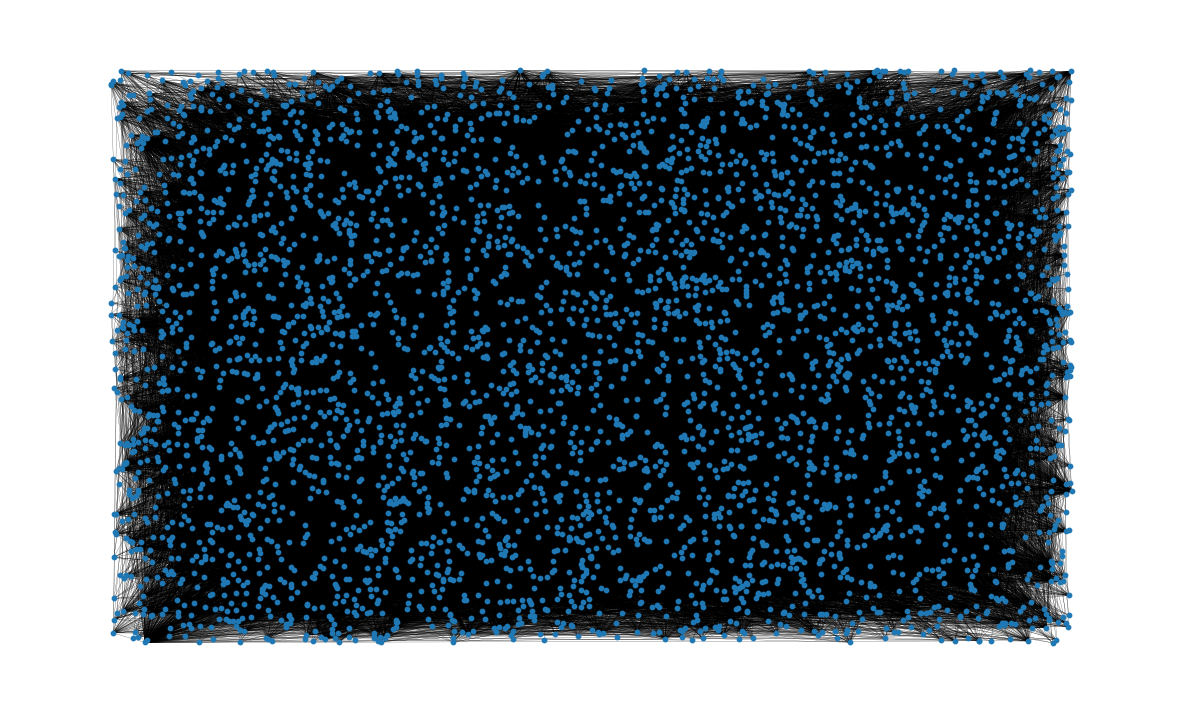

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Do we need more or less information (nodes or edges) from the graph to do the analysis? Let's check `spring_layout` and continue analysis...

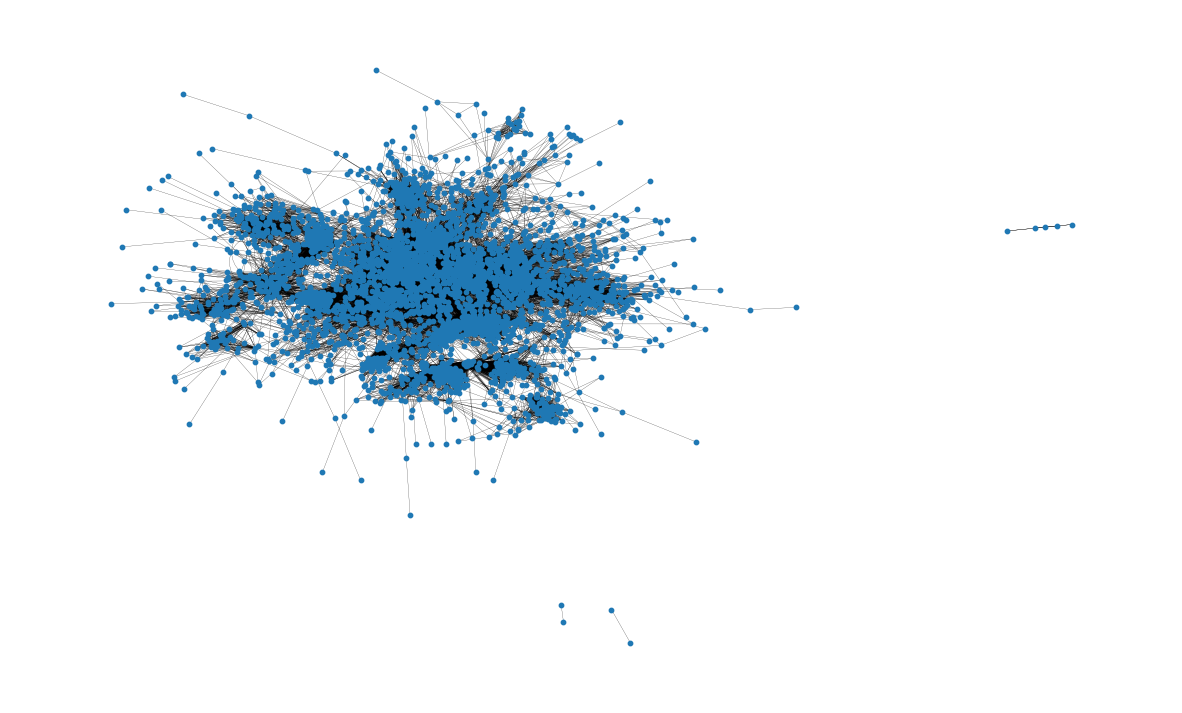

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

What other information can we extract from this network? ... (check graphs metrics)

Analisis Descriptivo

In [ ]:
#Conexiones entre los primeros 80.000 registros
twitter

,start_node,end_node
0,214328887,34428380
1,17116707,28465635
2,380580781,18996905
3,221036078,153460275
4,107830991,17868918
...,...,...
79995,245076474,16303106
79996,103991905,63273064
79997,222640532,15913
79998,15002416,123066394


In [ ]:
#Cantidad de nodos
G.number_of_nodes()

4316

In [ ]:
#Número de aristas
G.number_of_edges()

58270

In [ ]:
#En promedio los nodos tienen 27 conexiones cada perfil, o en otras palabras tienen en promedio, 27 seguidores
np.mean([d for _, d in G.degree()])

27.00185356811863

In [ ]:

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))


In [ ]:
# Calculo de las longitudes de los caminos más cortos entre todos los pares de nodos en el grafo
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

# Inicializa la suma de distancias y el contador de pares de nodos
total_distance_sum = 0
pair_count = 0

# Itera sobre el diccionario de distancias más cortas
for source_node, target_distances in shortest_path_lengths.items():
    for target_node, distance in target_distances.items():
        # Suma las distancias y cuenta los pares de nodos
        total_distance_sum += distance
        pair_count += 1

# Calcula el promedio de las distancias más cortas
average_shortest_path_length = total_distance_sum / pair_count

print("El promedio de las distancias más cortas entre todos los pares de nodos es:", average_shortest_path_length)

El promedio de las distancias más cortas entre todos los pares de nodos es: 4.957756558299215


In [ ]:
#Existen unos nodos que no tinen enlaces con los vecinos por tal motivo primero vamos a calcular
#el diametro de cada componente conectada Calcular el diámetro de la componente conectada utilizando las distancias más cortas precalculadas

def diameter_of_connected_component(G, shortest_path_lengths):

    connected_components = list(nx.connected_components(G))

    # Inicializar el diámetro
    diameter = 0

    # Calcular el diámetro de cada componente conectada
    for component in connected_components:
        # Crear un subgrafo de la componente conectada
        subgraph = G.subgraph(component)
        # Calcular el diámetro de la componente conectada utilizando las distancias más cortas precalculadas
        component_diameter = max(max(shortest_path_lengths[node].values()) for node in component)
        diameter = max(diameter, component_diameter)

    return diameter



In [ ]:

# Calcular las distancias más cortas entre todos los pares de nodos
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

diameter = diameter_of_connected_component(G, shortest_path_lengths)
print("Diámetro del grafo (ignorando nodos sin conexiones):", diameter)

Diámetro del grafo (ignorando nodos sin conexiones): 16


Text(0, 0.5, 'Frequency (%)')

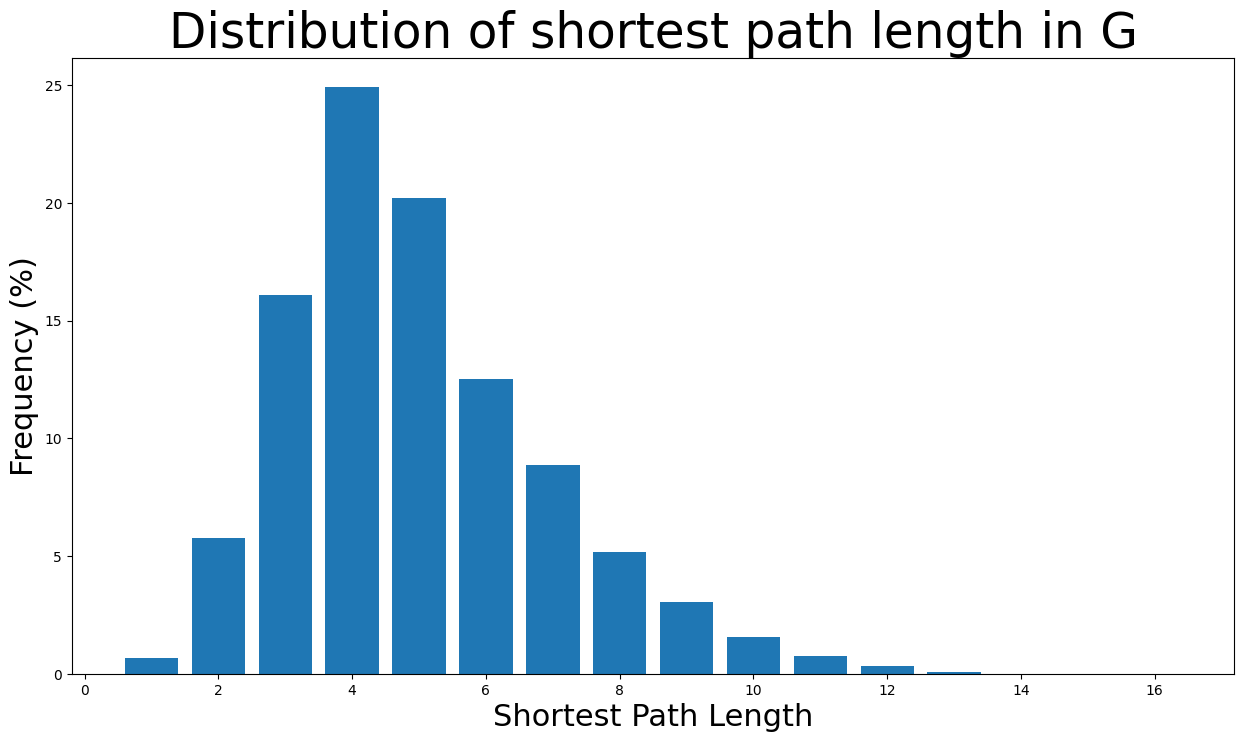

In [ ]:

path_lengths = np.zeros(diameter + 1, dtype=int)

#Extraer la frecuencia de las longitudes de ruta más cortas entre dos nodos
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts


freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()


fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

El 75% de los datos se encuentran conectados entre 3 y 6 vertices y es poco probable observar nodos conectados por 12 o más vertices (Menos del 1%).

In [ ]:
nx.density(G)

0.0062576717423218145

In [ ]:
#Existen 7 comunidades dentro de la muestra en las cuales los nodos cuentan con al menos un camino de conexion.
nx.number_connected_components(G)

7

GRADO DE CENTRALIDAD

Evalua la importancia de los nodos individuales dentro de una red

In [ ]:
degree_centrality = nx.centrality.degree_centrality(G)
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:7]

[(48485771, 0.07022016222479723),
 (5442012, 0.06813441483198146),
 (3359851, 0.06581691772885284),
 (40981798, 0.06257242178447277),
 (43003845, 0.0593279258400927),
 (34428380, 0.056315179606025494),
 (22462180, 0.05608342989571263)]

Se observa que los perfiles no tienen una alta centralidad ya que el que mas tiene es de un 7% de relevancia, eso quiere decir que si no existiera ese perfil, todavia existiria conexiones entre los otros perfiles

In [ ]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:7]

[(48485771, 303),
 (5442012, 294),
 (3359851, 284),
 (40981798, 270),
 (43003845, 256),
 (34428380, 243),
 (22462180, 242)]

El anterior codigo nos muestra los 7 perfiles con mas seguidores, o dicho de otra manera, los 7 perfiles mas influenciadores en donde el que tiene mas contactos es el perfil 48485771 con 303, mientras que el septimo perfil con mas contactos es el 22462180 con 242

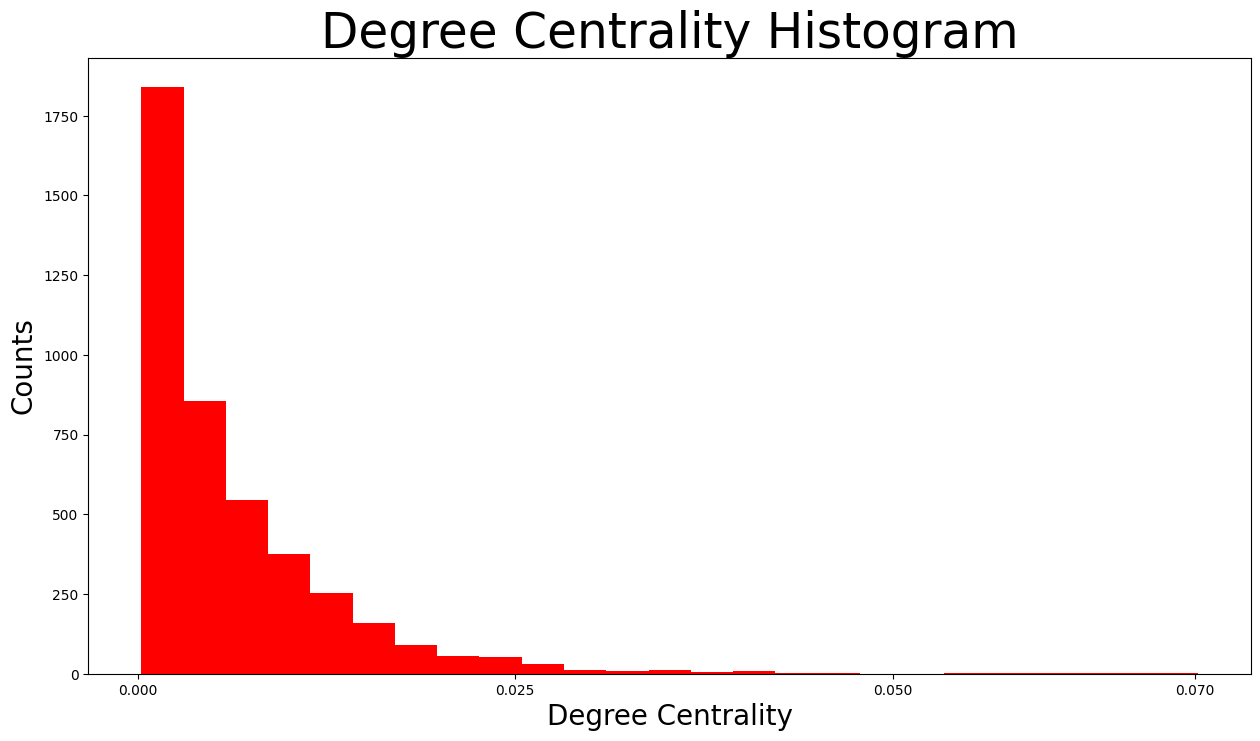

In [ ]:
degree_centrality_values = list(degree_centrality.values())

plt.figure(figsize=(15, 8))
plt.hist(degree_centrality_values, bins=25, color='red')
plt.xticks(ticks=[0, 0.025, 0.05, 0.07])
plt.title("Degree Centrality Histogram", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})
plt.show()

hay mas de 1750 nodos cuya importancia es relativamente baja estando por debajo del 0.05 del indicador de centralidad. Mientras que el que existen menos de 10 casos con un grado de centralidad mayor a 0.05, a quienes podriamos denominar como Influencers dentro de twitter.

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

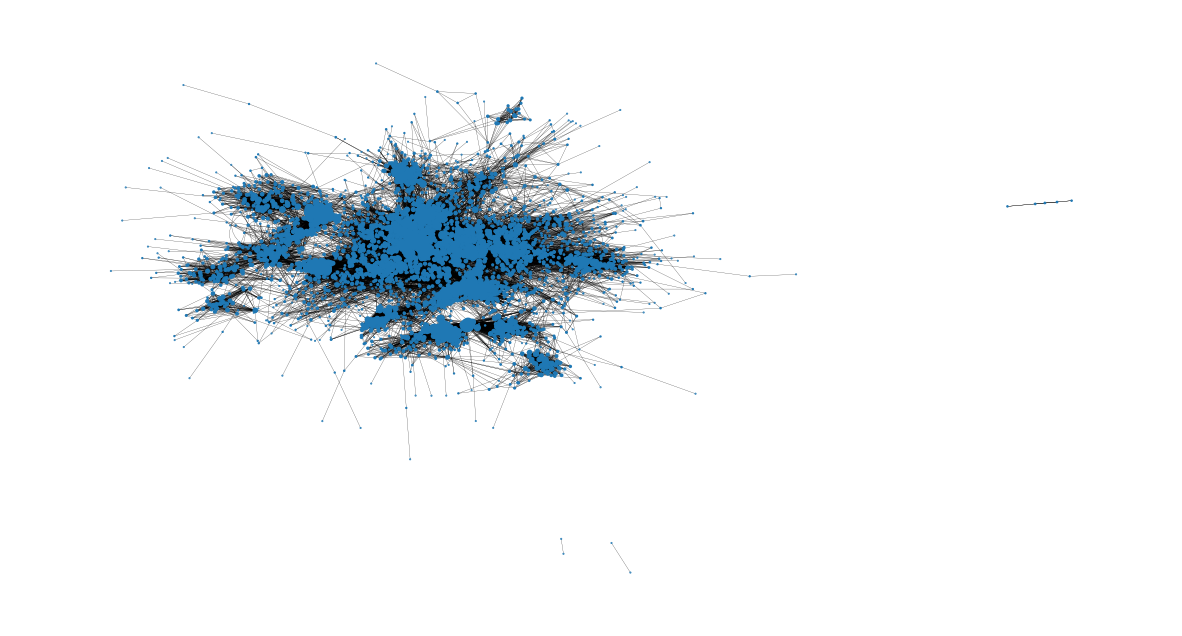

In [ ]:
#comprobar los usuarios con el grado más alto de centralidades a partir del tamaño de sus nodos
node_size = [v * 1000 for v in degree_centrality.values()]
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

En el gráfico anterior se aprecia que hay unos perfiles que tienen un grado de centralidad a medida que el circulo azul es mas grande. Sin embargo, se observa que la centralidad es muy dispersa dentro de la muestra tomada en twitter y no hay una diferenciación en que haya un influencer mucho mas grande que todos los demas influenciadores

CENTRALIDAD INTERMEDIA

Nos indica como un nodo puede actuar como puente entre otros nodos

In [ ]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:7]

[(6207392, 0.1725645640056724),
 (3359851, 0.15443758920551148),
 (783214, 0.0975291202117271),
 (41716273, 0.09272687817377762),
 (17093617, 0.09073724589851986),
 (27634404, 0.08587007531097253),
 (15666380, 0.07953763787324364)]

Podemos deducir que los temas de cada "Influencer" en sus comunidades tienen poca relación entre ellos, ya que los indices de centranlidad de intermediación estan por debajo del 17%. En donde se destaca que solo hay dos nodos (6207392 - 3359851) que tienen una intermediación superior al 15% mientras que los demás nodos con mayor intermediación estan por debajo del 10% lo cual indica poca conexión entre los componentes.

Text(0, 0.5, 'Counts')

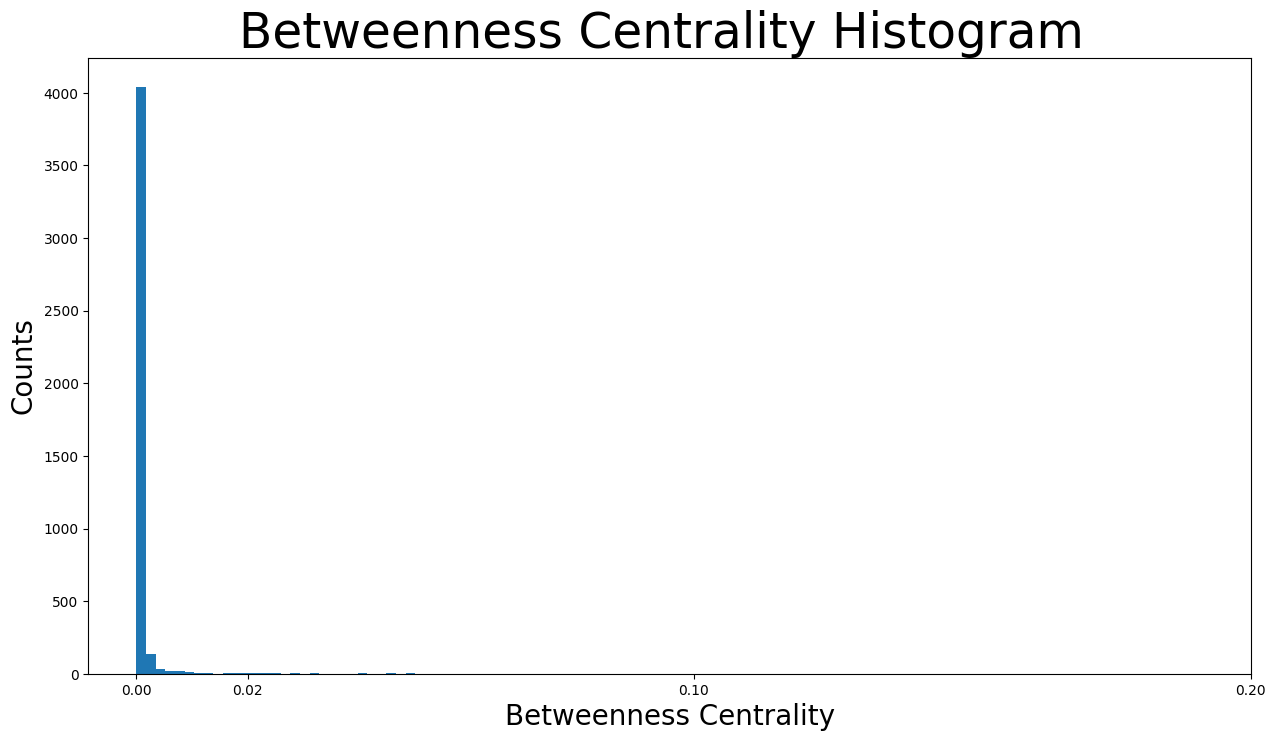

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2])
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

En la gráfica anterior se evidencia que son muy pocos los perfiles que sirven como puentes de otras comunidades ya que están cercanos entre el 0%-2%

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

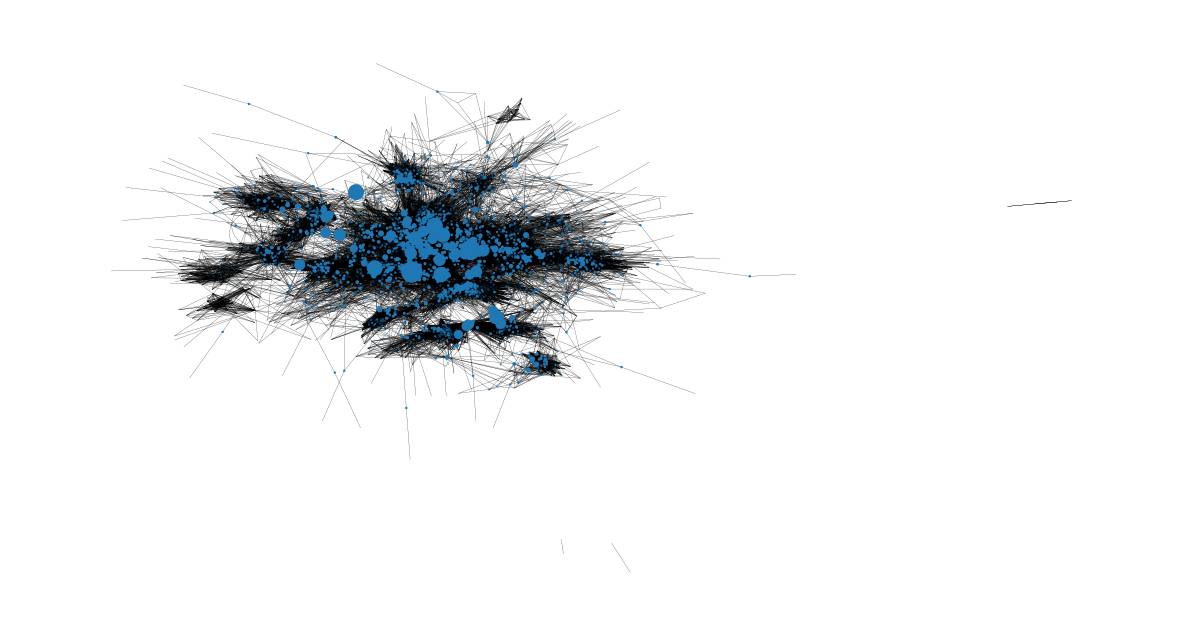

In [ ]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

En el grafo anterior se puede apreciar que hay perfiles que sirven como puentes entre comunidades de twitter y unos mas relevantes que otros, los cuales están centralizados en el nodo. Esto puede suponer que sean perfiles de reporteros reconocidos de noticias que tienen contactos de diversos influenciadores de distintos temas

CENTRALIDAD DE CERCANIA

Nos indica que tan cerca esta un nodo de otros nodos.

In [ ]:
#Calcular el nodo con mayor cercania
closeness_centrality = nx.centrality.closeness_centrality(G)
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:7]

[(3359851, 0.3174907000782523),
 (15234657, 0.2989200839846593),
 (48485771, 0.2947102540271258),
 (7860742, 0.293730499193259),
 (15666380, 0.2907448655999966),
 (20880546, 0.29061735524303445),
 (3829151, 0.2868847706962951)]

En nodo 3359851 es el que más rapido propaga la infomación por medio de la red a sus seguidores


In [ ]:
1 / closeness_centrality[3359851]

3.149698557323187

La distancia entre el nodo 3359851 con un nodo aleatorio es de aproximadamente 3 tweets.

Text(0, 0.5, 'Counts')

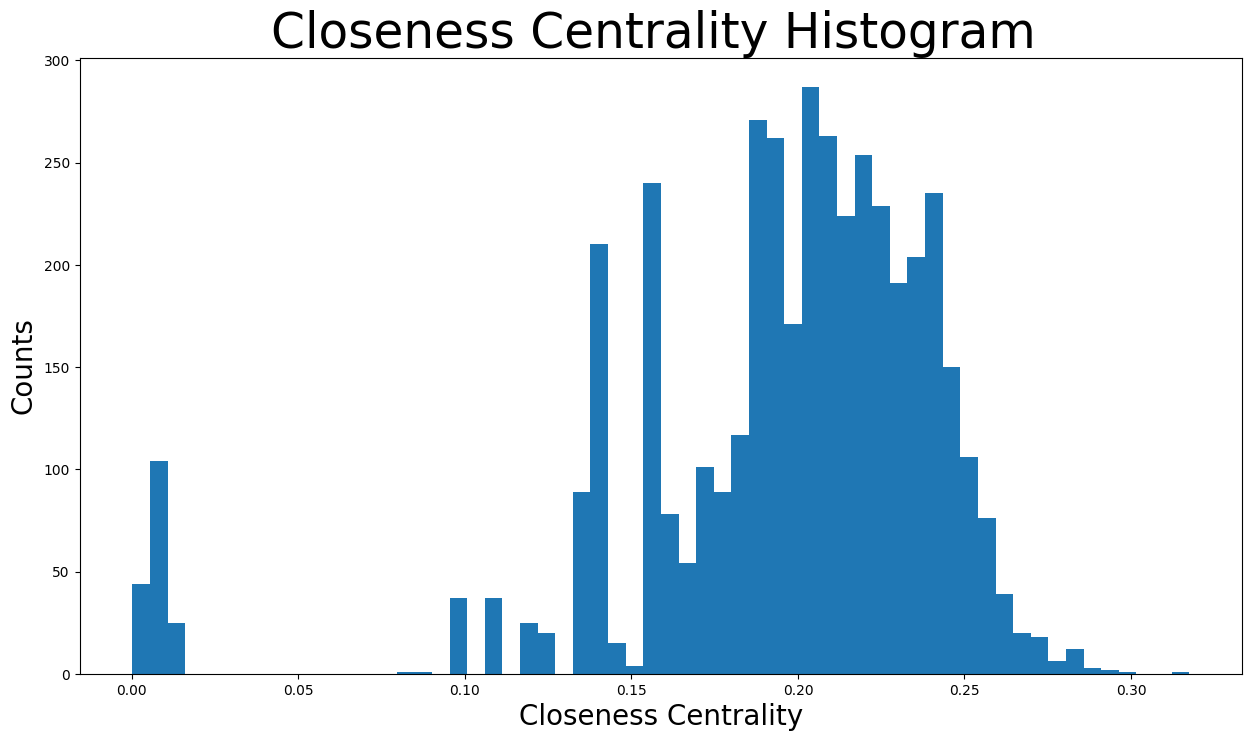

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

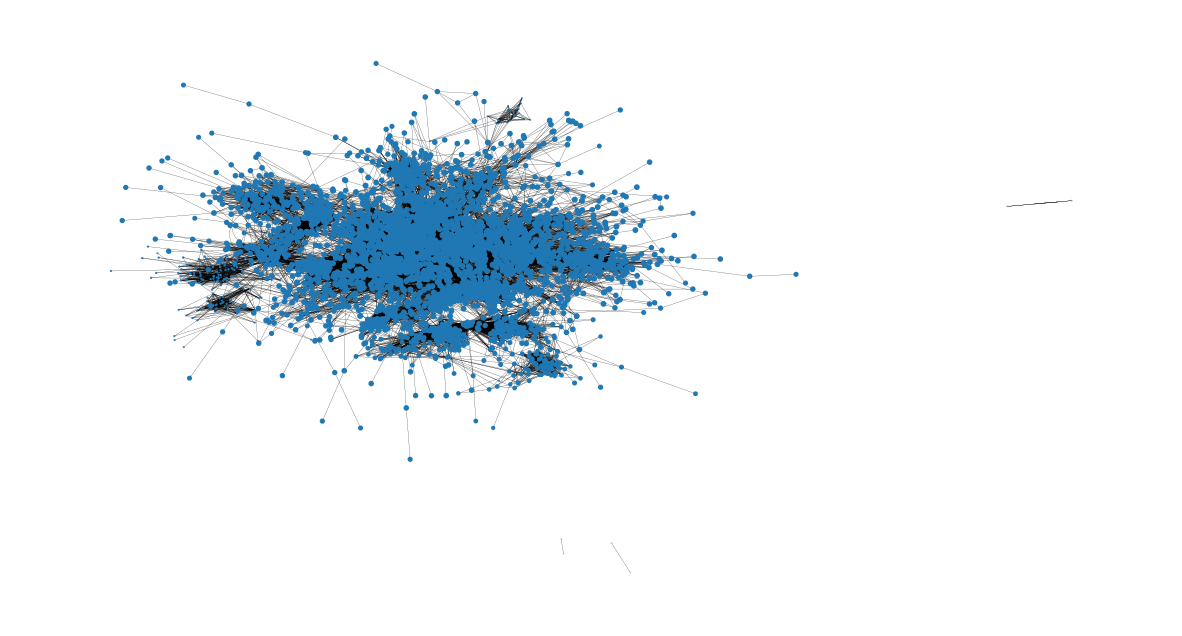

In [ ]:
node_size = [ v * 50 for v in closeness_centrality.values()]
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

El grafo evidencia que todos los perfiles, sobre todo los del centro, tienen un grado de centralidad de cercania similar y no se diferencia en que exista uno con tantos cercanos al resto de los nodos

Eigenvector Centrality

Importanacia de los nodos si sus nodos vecinos son importantes de igual forma. Es dicir, un tuit es importante si es referenciado por alguien considerado importante

In [ ]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:15]

[(40981798, 0.15363590744821665),
 (43003845, 0.1507372702636457),
 (22462180, 0.14898138833635383),
 (34428380, 0.14836888505482648),
 (153226312, 0.11747403879993272),
 (270449528, 0.11544891170259039),
 (83943787, 0.11509706228160357),
 (17868918, 0.11470184783932444),
 (151338729, 0.11429285736480958),
 (279787626, 0.1140975626333083),
 (358775055, 0.11409508655361804),
 (463952369, 0.11276760663140128),
 (18996905, 0.11211662845355672),
 (100581193, 0.11188885315789533),
 (134940306, 0.11175098579376017)]

El perfil 40981798 es el que más interación tiene con perfiles influencers





In [ ]:
#Validar como se conectan los nodos de la muestra con el más importante (40981798)
high_eigenvector_centralities = (sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[1:15]
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities]
neighbors_1912 = [n for n in G.neighbors(40981798)]
all(item in neighbors_1912 for item in high_eigenvector_nodes)

True

Text(0, 0.5, 'Counts')

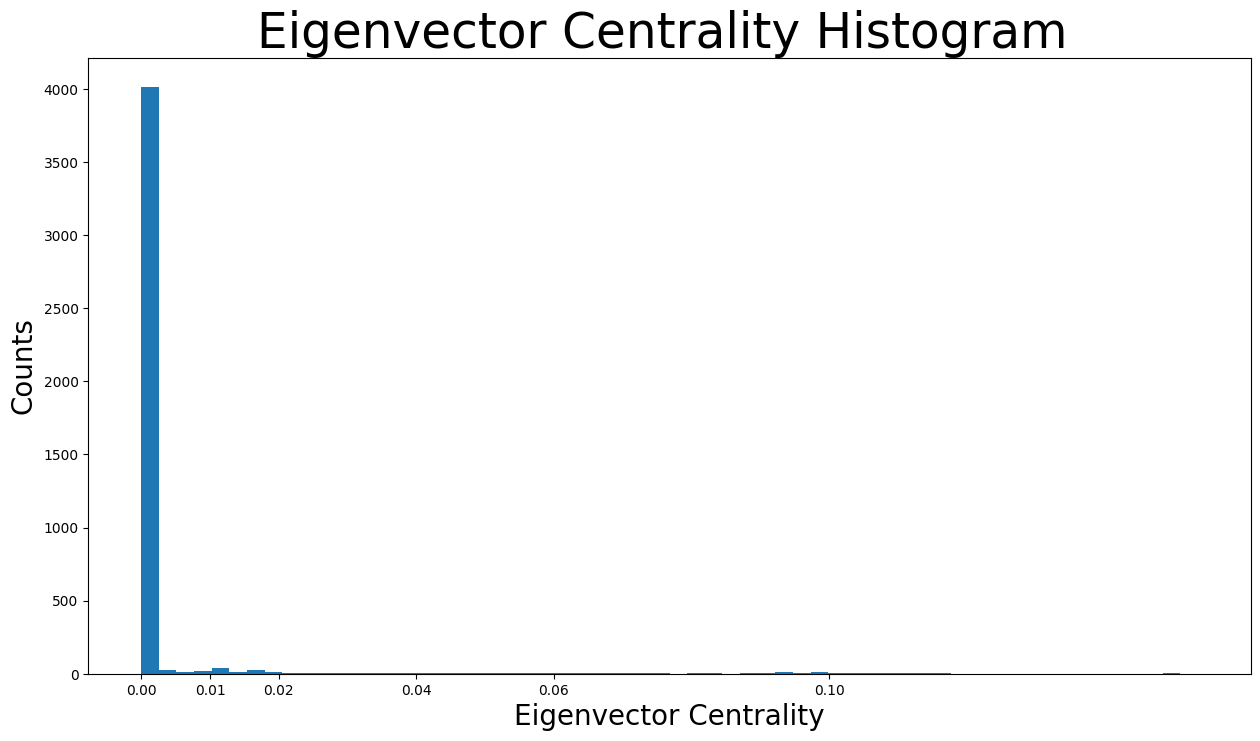

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.1])  # set the x axis ticks
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

En el anterior gráfico se evidencia que cerca de 4000 perfiles tienen un nivel bajo de centralidad de vector propio, dando a entender que tienen baja importancia o influencia relativa de los nodos en la red.

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

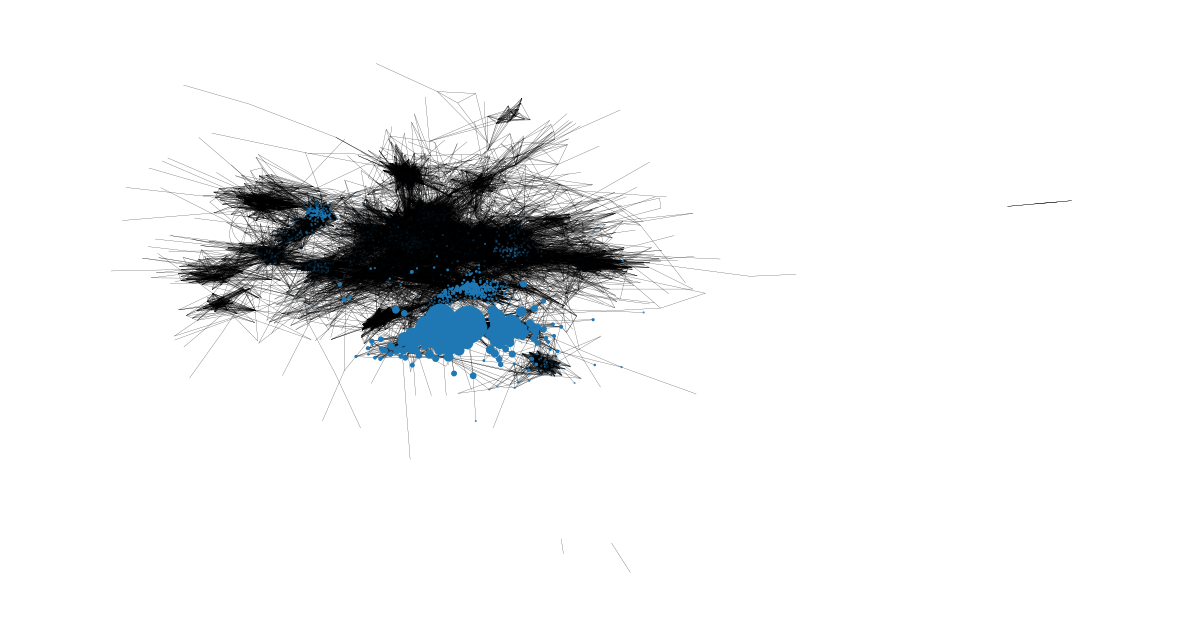

In [ ]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

Se observa que los perfiles que se encuentran en la parte inferior del grafo, son los que tienen un mayor grado de centralidad de vector propio y esto tiene sentido porque tiene una alta influencia de conectarse a si mismos

COEFICIENTE DE AGRUPAMIENTO

Indica la proporción de conexiones entre los vecinos de un nodo en relación con el número total de conexiones posibles entre esos vecinos.

In [ ]:
nx.average_clustering(G)

0.4949716847236492

El coeficiente de agrupamiento que resultó indica lo siguiente:

Sugiere que, en promedio, los amigos de un usuario en Twitter tienden a estar conectados entre sí. Esto puede reflejar la tendencia de que los amigos de un usuario también sean amigos entre sí en la red social

Indica la posible existencia de comunidades o grupos de usuarios dentro de la red de Twitter

Tiene una difusión de información con una velocidad media

Text(0, 0.5, 'Counts')

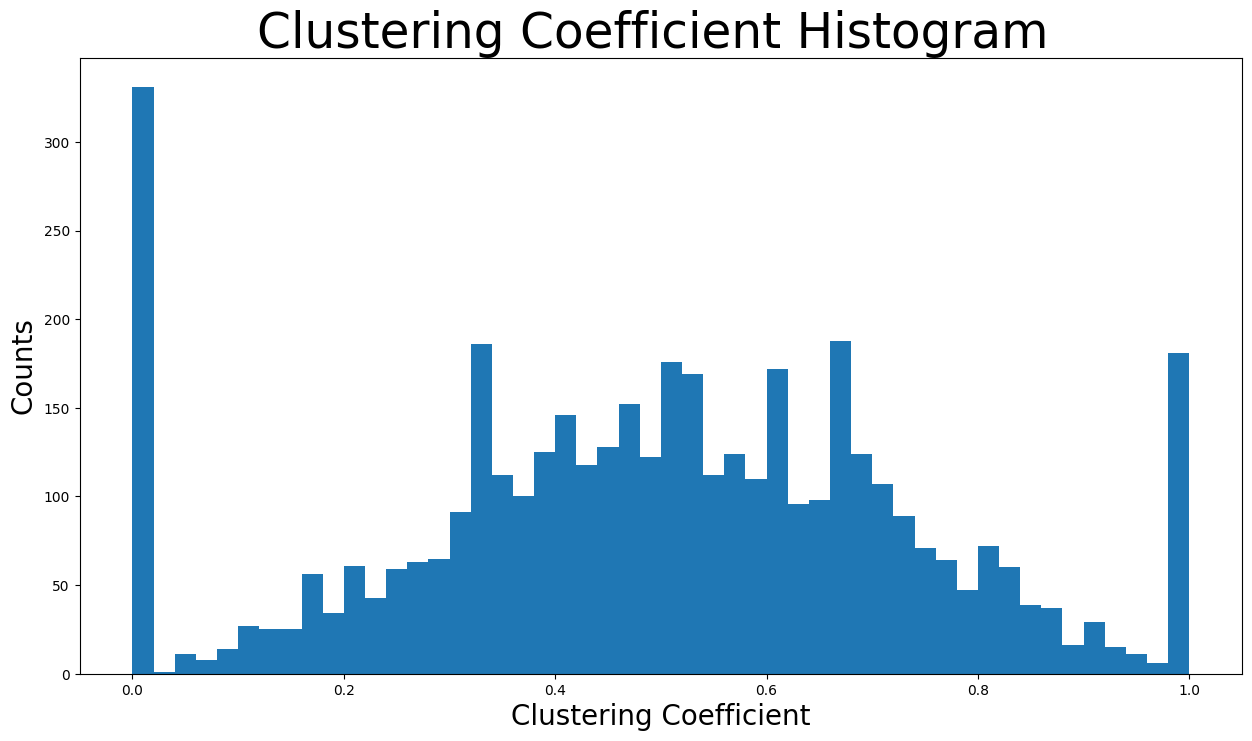

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Se observa que el histograma tiene una distribución normal, salvo la primera y ultima barra

La primera barra nos indica que existen mas de 300 perfiles que no se agrupan en comunidades

La ultima barra indica que existen cerca de 180 perfiles que forman una comunidad perfectamente concentrada, eso quiere decir que es una comunidad bien formada con perfiles que se interactuan muy similar dentro de la red social

In [ ]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3

465759.0

El anterior resultado, indica que hay un total de 465759 triángulos cerrados en la red de perfiles de Twitter con las interacciones consideradas. Cada triángulo está formado por tres perfiles que están conectados entre sí a través de sus interacciones mutuas.

In [ ]:
#Número promedio de triángulos de los que forma parte un nodo
np.mean(triangles_per_node)

323.7435125115848

Se refleja que cada perfil en promedio interactua con 324 comunidades de tripletas cerradas

In [ ]:
#Calculo de la mediana
np.median(triangles_per_node)

71.0

El nodo de la mitad del grafo interactua en promedio con 71 comunidades de tripletas cerradas

In [ ]:
#comprobar si hay puentes en la red
nx.has_bridges(G)

True

In [ ]:
#Cantidad de aristas puentes
bridges = list(nx.bridges(G))
len(bridges)

209

In [ ]:
#Calculo de arista que si se eliminan desconectaría el grafo localmente, es decir,
# separaría una comunidad de nodos del resto del grafo.
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

987

Se aprecia que hay 987 perfiles como puentes locales, que si se desconectan, podrían afectar la conectividad global de la red

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

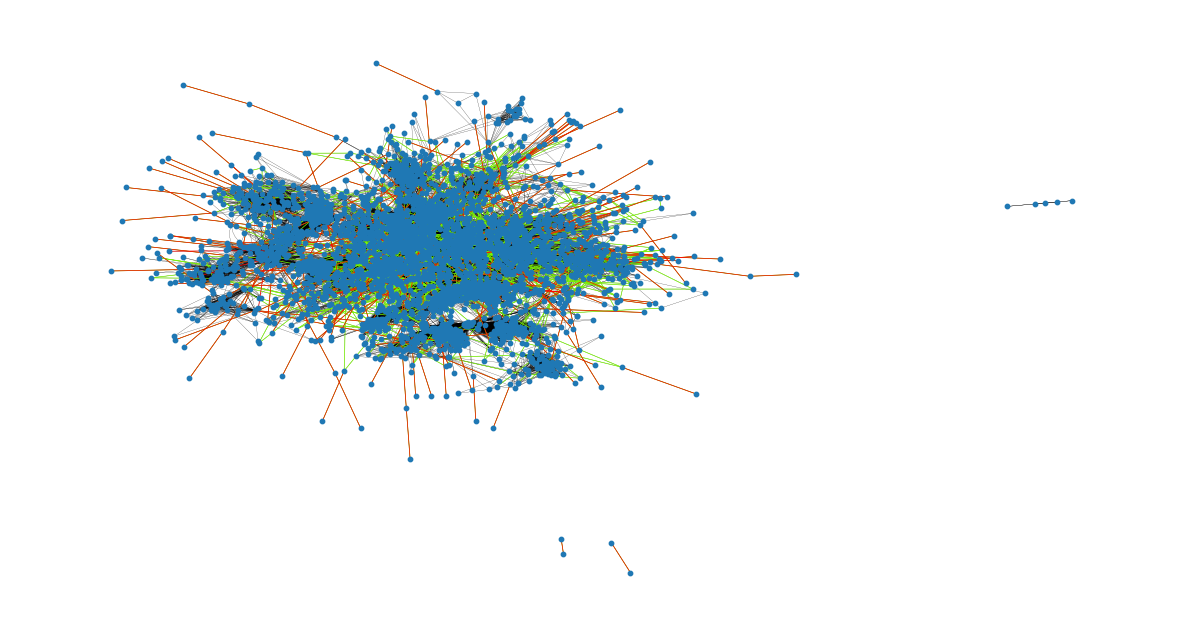

In [ ]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)
plt.axis("off")

El grafo anterior muestra que los puentes locales están distribuidos en todas partes de forma pareja, esto se puede interpretar que la red social es sensible de desconectarse si hay perfiles masivos que se desconectan de forma simultanea

Assortativity


Describe la preferencia de los nodos de una red por conectarse a otros que son similares de alguna manera.



In [ ]:
nx.degree_assortativity_coefficient(G)

0.07572773506976808

El coeficiente de asortatividad indica que los perfiles tienden ligeramente a conectarse preferentemente con otros perfiles que tienen características similares. Sin embargo, se observa un nivel de aleatoriedad en que los perfiles interactuan entre si y esto es congruente con lo que pasa en esta red social que salen tweets de personas que no conoces o tweets de temas que no te interesan

In [ ]:
nx.degree_pearson_correlation_coefficient(G)

0.07572773506976584

Network Communities

In [ ]:
colors = [""] * G.number_of_nodes()  # Inicializa la lista de colores con la longitud adecuada
node_index_map = {node: i for i, node in enumerate(G.nodes())}  # Mapa de nodos a índices en la lista colors
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # Crea un color RGB aleatorio
    counter += 1
    for node in list(com):
        colors[node_index_map[node]] = color
counter

88

Se identificaron 88 comunidades dentro del grafo

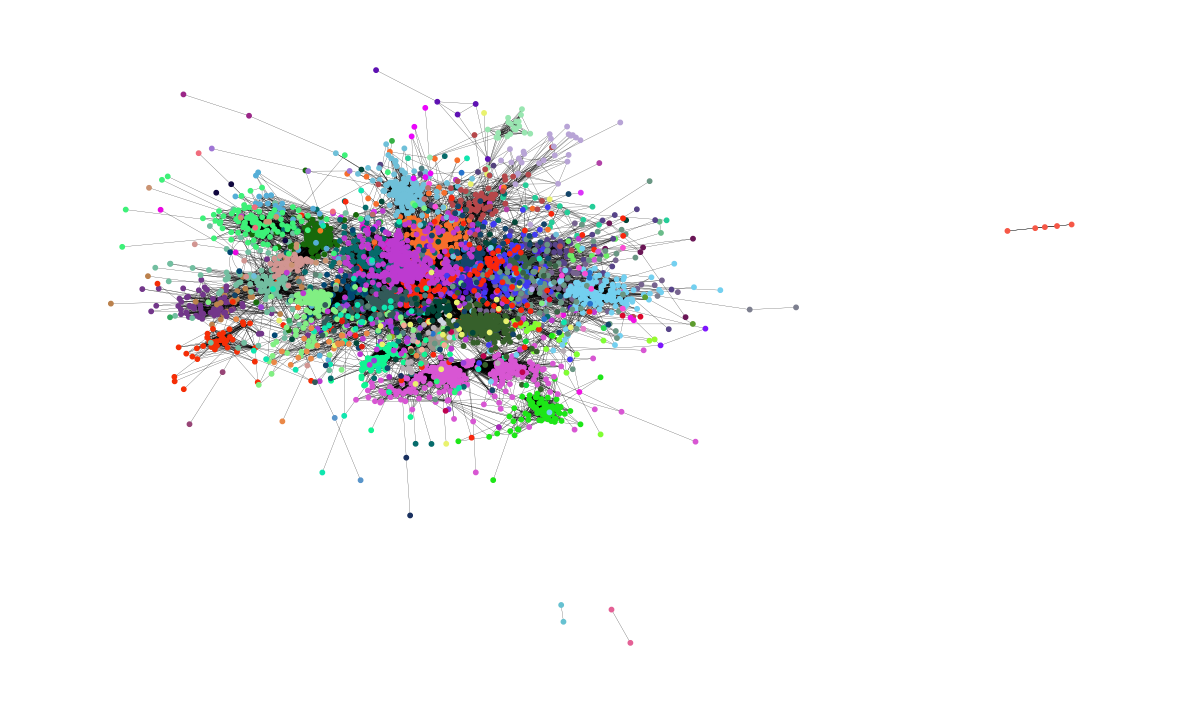

In [ ]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors)

Este grafo se diferenció por colores los perfiles de acuerdo a las 88 comunidades que se agruparon. Acá se puede observar que las comunidades en purpura claro están divididos en dos grupos. Esto puede ser que sean perfiles con las mismas preferencias pero que son de una región o cultura diferente. Tambien se aprecia algo similar con una comunidad azul clara que están en dos partes del grafo (en la parte superior izquierda). Tambien cabe destacar que hay perfiles que están conectados con otros perfiles pero que son de diferentes comunidades como se observa en el centro del grafo en donde hay perfiles conectados de comunidades del color azul rey y naranja

In [ ]:
#Eliminar los nodos que no estan alejados
import networkx as nx
from random import randint


# Obtener las componentes conectadas
connected_components = list(nx.connected_components(G))

# Encontrar el componente más grande
largest_component_nodes = max(connected_components, key=len)
largest_component = G.subgraph(largest_component_nodes)

# Inicializar la lista de colores con la longitud adecuada
colors = [""] * largest_component.number_of_nodes()

# Ejecutar el algoritmo de detección de comunidades en el componente más grande
for com in nx.community.asyn_fluidc(largest_component, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # Crear un color RGB aleatorio
    for node in list(com):
        # Verificar que el nodo está en el subgrafo
        if node in largest_component:
            # Obtener el índice del nodo en el subgrafo
            node_index = list(largest_component.nodes()).index(node)
            colors[node_index] = color

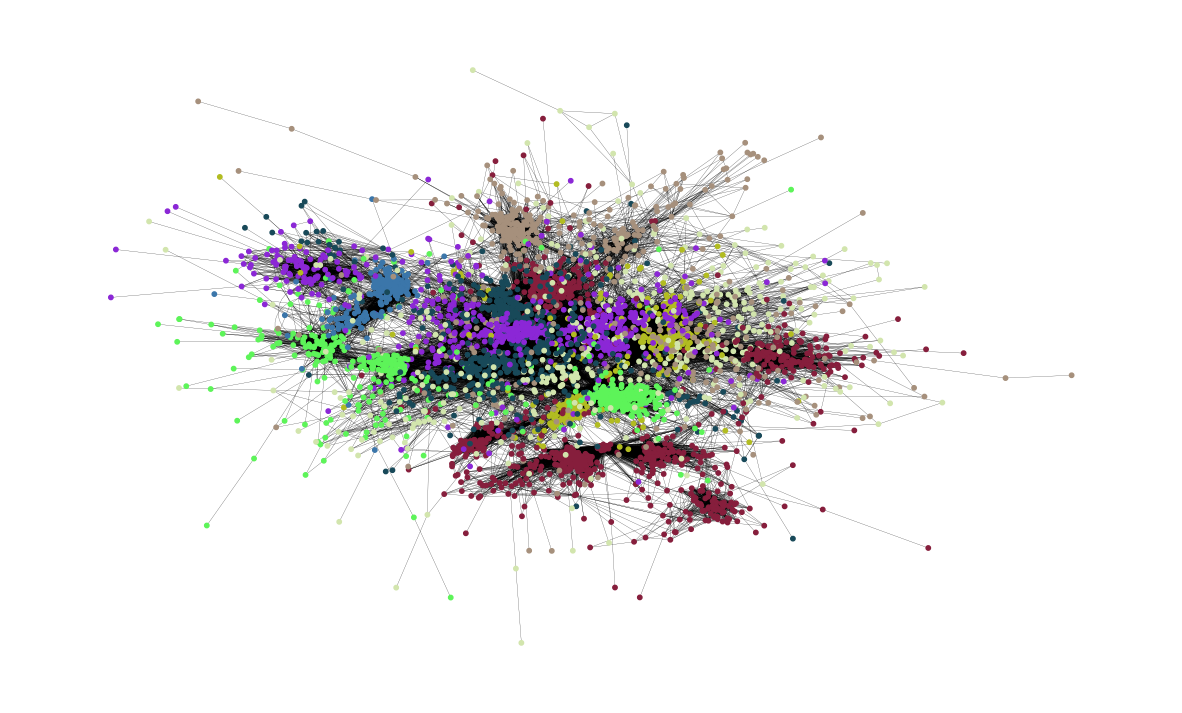

In [ ]:
connected_components = list(nx.connected_components(G))

# Encontrar el componente más grande
largest_component_nodes = max(connected_components, key=len)
largest_component = G.subgraph(largest_component_nodes)

# Inicializar la lista de colores con la longitud adecuada
colors = [""] * largest_component.number_of_nodes()

# Ejecutar el algoritmo de detección de comunidades en el componente más grande
for com in nx.community.asyn_fluidc(largest_component, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # Crear un color RGB aleatorio
    for node in list(com):
        # Verificar que el nodo está en el subgrafo
        if node in largest_component:
            # Obtener el índice del nodo en el subgrafo
            node_index = list(largest_component.nodes()).index(node)
            colors[node_index] = color  # Asignar el color al nodo en el índice correspondiente

# Dibujar el grafo con colores asignados a los nodos
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    largest_component, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)
plt.show()

En el anterior grafo se eliminan los perfiles aislados y se agrupan los perfiles a 8 componentes en donde se aprecia que la comunidad mas grande es la vinotinto (pese a estar dividida en 6 partes del grafo), luego  le sigue la morada claro que está ubicada en la parte central del grafo. Por otro lado, se aprecia que la comunidad mas pequeña es la dorada amarillo la cual está dispersa en la parte central derecha del grafo